In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [26]:
class Generator:
    
    def __init__(self):
        self.rows = 50
        self.cols = 50
    
    def widen(self, racetrack, start_cell, end_cell):
        k = 1
        while(1):
            if ((start_cell[1] < k) or (start_cell[0] < k)):
                racetrack[0:end_cell[0],0:end_cell[1]] = -1
                break
            if ((end_cell[1]+k > self.cols) or (end_cell[0]+k > self.rows)):
                racetrack[start_cell[0]:self.rows,start_cell[1]:self.cols] = -1
                break
            k += 1
        return racetrack
    
    def calculate_valid_fraction(self, racetrack):
        return (len(racetrack[racetrack==0])/(self.rows*self.cols))

    def mark_finish_states(self, racetrack):
        last_col = racetrack[0:self.rows,self.cols-1]
        last_col[last_col==0] = 2
        return racetrack
    
    def mark_start_states(self, racetrack):
        last_row = racetrack[self.rows-1,0:self.cols]
        last_row[last_row==0] = 1
        return racetrack
    
    def generate_racetrack(self):
        racetrack = np.zeros((self.rows,self.cols),dtype='int')
        frac = 1
        while frac > 0.5:    
            random_cell = np.random.randint((self.rows,self.cols))
            random_hole_dims = np.random.randint((self.rows//4,self.cols//4))
            start_cell = np.array([max(0,x - y//2) for x,y in zip(random_cell,random_hole_dims)])
            end_cell = np.array([min(z,x+y) for x,y,z in zip(start_cell,random_hole_dims,[self.rows,self.cols])])
            racetrack = self.widen(racetrack, start_cell, end_cell)
            frac = self.calculate_valid_fraction(racetrack)
        racetrack = self.mark_start_states(racetrack)
        racetrack = self.mark_finish_states(racetrack)
        return racetrack

In [27]:
class Environment:
    
    def __init__(self):
        
        self.track = Generator().generate_racetrack()
        self.start = np.array(np.where(self.track == 1)).T
        self.finish = np.array(np.where(self.track == 2)).T
        self.outbounds = np.array(np.where(self.track == -1)).T
        self.inbounds = np.array(np.where(self.track == 0)).T
        
    def draw(self):
        plt.imshow(self.track)

In [28]:
class Agent:
    
    def __init__(self, env):
        self.env = env
        self.actions = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,0), (0,1), (1,-1), (1,0), (1,1)]
        self.q = self.arb_q()
        self.c = self.arb_c()
        self.p = self.arb_p()
        self.x_vel = 0
        self.y_vel = 0
        self.x, self.y = env.start[np.random.choice(len(env.start))]
        self.terminated = False
        
    def arb_q(self):
        q = {}
        for x, y in np.concatenate([self.env.inbounds, self.env.start, self.env.finish]):
            for x_vel in range(1,6):
                for y_vel in range(1, 6):
                    for action in self.actions:
                        q[tuple(x, y, x_vel, y_vel), action] = np.random.rand()
        return q
    
    def arb_c(self):
        c = {}
        for x, y in np.concatenate([self.env.inbounds, self.env.start, self.env.finish]):
            for x_vel in range(1,6):
                for y_vel in range(1, 6):
                    for action in self.actions:
                        c[tuple(x, y, x_vel, y_vel), action] = 0
        return c
    
    def arb_p(self):
        p = {}
        for state in np.concatenate([self.env.inbounds, self.env.start, self.env.finish]):
            
            p[tuple(state)] = self.random_action()
        return p
    
    def restart(self):
        self.x, self.y = env.start[np.random.choice(len(env.start))]
        self.x_vel = 0
        self.y_vel = 0

    def action(self, action):
        x, y = action[0], action[1]
        self.x_vel = np.clip(self.x_vel+x, 0, 5)
        self.y_vel = np.clip(self.y_vel+y, 0, 5)
    
    def drive(self):
        if ([self.x-self.x_vel, self.y-self.y_vel] not in env.inbounds.tolist()):
            return -1
            self.restart()
        elif ([self.x-self.x_vel, self.y-self.y_vel] in env.finish.tolist()):
            self.terminated = True
            return 1
        else:
            self.x-=self.x_vel
            self.y-=self.y_vel
            return -1
        
    def random_action(self):
        return self.actions[np.random.choice(len(self.actions))]
        
    def play(self, step_threshold, epsilon):
        self.restart()
        episode = []
        for step in range(step_threshold):
            state = tuple((self.x, self.y))
            action = [self.p[state], self.random_action()][np.random.choice([0, 1], p=[1-epsilon, epsilon])]
            self.action(tuple(action))
            reward = self.drive()
            episode.append(state)
            episode.append(action)
            episode.append(reward)
            if action != self.p[state]:
                episode.append(1 - epsilon + epsilon/len(self.actions))
            else:
                episode.append(epsilon/len(self.actions))
            if self.terminated:
                break
        return episode

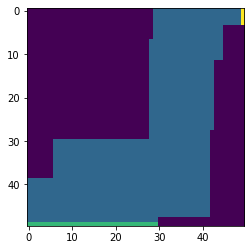

In [30]:
env = Environment()
env.draw()
# agent = Agent(env)
# gamma = 0.99
# epsilon = 0.1
# epochs = 100
# step_threshold = 2000

In [7]:
exp_rewards = []

for epoch in tqdm(range(epochs)):
    
    episode = agent.play(step_threshold, epsilon)
    
    G = 0
    W = 1

    states = episode[0:][::4]
    actions = episode[1:][::4]
    rewards = episode[2:][::4]
    probs = episode[3:][::4]

    episode = list(zip(states, actions, rewards, probs))
    
    exp_rewards.append(sum(gamma**T * reward for T, reward in enumerate(rewards)))

    for T, step in enumerate(reversed(episode)):

        state, action, reward, prob = step
        G = gamma * G + int(reward)
        agent.c[state, action]+=W
        agent.q[state, action] = agent.q[state, action] + W/agent.c[state, action] * (G-agent.q[state, action])
        agent.p[state, action] = max(agent.actions, key= lambda a: agent.q[state, a])
        if action != agent.p[state, action]:
            break
        W/= prob

100%|██████████| 100/100 [05:39<00:00,  3.39s/it]


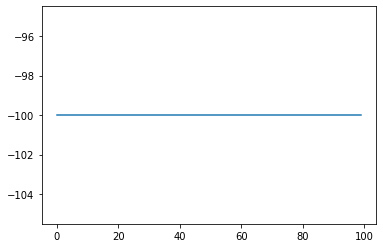

In [8]:
plt.plot(exp_rewards)

In [9]:
episode

[((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1), -1, 0.011111111111111112),
 ((99, 14), (-1, -1)